# DSCI 100: Group Project

## Classification of Facebook Post Type Using Social Media Performance Metrics

#### Introduction:

The rapid advancement of technology has transformed the business world. Social media platforms have become the best place for businesses to advertise their brands by increasing customer engagement. 
Our report focuses on the most popular social network worldwide, Facebook, with over 2.7 billion monthly active users [1]. 

The dataset *Facebook performance metrics* [2] contains data related to posts published throughout the year 2014 on a renowned cosmetics brand's Facebook page. Post information such as type (photo, status, link, or video), time posted (month, day of week, and hour), user engagement (comments, likes, and shares), impressions on each post (too many columns to list here), and whether the post was paid or unpaid is included in the dataset. 

This project uses all relevant columns from this dataset to determine the type of a brand's Facebook post. We determine which of these metrics are relevant in our cleaning and exploration of the data. We use our chosen predictors to build a prediction model using the K-nearest neighbour classification algorithm, implemented in the `tidymodels` framework, to predict the type of a post (photo, status, link, or video).

#### Preliminary exploratory data analysis:

We begin by loading the relevant libraries. 

In [1]:
# We include tidymodels for the KNN classification algorithm,
# and GGally for the ggpairs plotting function.
# Load libraries for preliminary data analysis:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Next, we load the dataset and count the number of n/a.

In [3]:
# displays first and last 8 rows of the dataset
options(repr.matrix.max.rows = 16)
# Set the seed
set.seed(123)

# The original dataset was contained in a zip file,
# we extracted and pushed the file to Github repository.
# Load the data in
fb_data_raw <- read_csv2("https://gist.githubusercontent.com/KolCrooks/691e5890b6747b4777d6032f019b2c0f/raw/20629a5da3d5a7683e3071798876f3e4b204fbbb/fb_data.csv",  col_types = cols())
fb_data_raw

# NA Rows:
sum(is.na(fb_data_raw))

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186
139441,Photo,3,12,1,3,1,11692,19479,481,265,364,15432,9328,379,3,249,27,279
139441,Photo,3,12,7,9,1,13720,24137,537,232,305,19728,11056,422,0,325,14,339
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


[1] 6

The dataset is already in tidy format. The column headings were made more usable by removing spaces and shortening longer headings. We find that we have 6 NAs in our data set, so we use `na.omit` function to remove them. Secondly, we set our target, `type`, as a factor. In addition, we need to give those columns readable names.

In [4]:
# Clean the data, change column names, and convert some columns to factors:
fb_data_clean_cols <- fb_data_raw
colnames(fb_data_clean_cols) <- c("page_likes", "type", "category", "post_month", "post_weekday", "post_hour", "paid", "reach", 
      "impressions", "engaged_users", "post_consumers", "post_consumptions", "impressions_by_people_that_liked_page", 
      "reach_by_people_that_like_page", "people_liked_and_engaged", "comments", "likes", "shares", "interactions")
fb_data_clean <- fb_data_clean_cols %>% 
        mutate(type = as_factor(type)) %>% 
#         mutate(category = as_factor(category)) %>% 
#         mutate(post_month = as_factor(post_month)) %>% 
#         mutate(post_weekday = as_factor(post_weekday)) %>% 
#         mutate(post_hour = as_factor(post_hour)) %>% 
#         mutate(paid = as_factor(paid)) %>% 
        na.omit()

fb_data_clean

page_likes,type,category,post_month,post_weekday,post_hour,paid,reach,impressions,engaged_users,post_consumers,post_consumptions,impressions_by_people_that_liked_page,reach_by_people_that_like_page,people_liked_and_engaged,comments,likes,shares,interactions
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186
139441,Photo,3,12,1,3,1,11692,19479,481,265,364,15432,9328,379,3,249,27,279
139441,Photo,3,12,7,9,1,13720,24137,537,232,305,19728,11056,422,0,325,14,339
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


Here, we split our data set into a training set and a testing set using the `initial_split` function. We do this so that we can train our KNN classifier using only the training set; then, to evaluate the accuracy of the classifier, we can use it to predict the posts' types (which we know) in the test set. Typically, we choose 50% ~100% of the data as traning set. In order to train a more accurate model while still having an accurate evaluation of its performance, we allocate 75% of our data for training and reserve 25% for testing. As we want to classify post type as our target variable, we pass `type` as the `strata` argument in `initial_split`. 

In [4]:
# Split the data:
fb_split <- initial_split(fb_data_clean, prop = 0.75, strata = type)
fb_train <- training(fb_split)
fb_test <- testing(fb_split)

# ensure fb_train and fb_test contain 75% and 25% of data, respectively
nrow(fb_train)
nrow(fb_test)

[1] 372

[1] 123

#### Selecting our predictors:

To figure out which predictors to use, we use `ggpairs` to determine how well each column can predict post type. To do this we will compare each post type's box plot with that of the potential predictor.  Before using ggpairs, we want to take out the columns that we already know will not work; this will reduce clutter in the plot while allowing us to more accurately compare the remaing predictors.

The columns we know we cannot use as predictors are categorical data: the time-based columns `post_month`, `post_weekday`, and `post_hour`, and the columns `category` and `paid`. We perform these adjustments to both the training set and the testing set, to ensure that we do not end up with differing columns that will affect the results or interpretation of our model.

In [5]:
# Columns before selection
colnames(fb_train)

colnames(fb_test)

[1] "page_likes"                           
 [2] "type"                                 
 [3] "category"                             
 [4] "post_month"                           
 [5] "post_weekday"                         
 [6] "post_hour"                            
 [7] "paid"                                 
 [8] "reach"                                
 [9] "impressions"                          
[10] "engaged_users"                        
[11] "post_consumers"                       
[12] "post_consumptions"                    
[13] "impressions_by_people_that_liked_page"
[14] "reach_by_people_that_like_page"       
[15] "people_liked_and_engaged"             
[16] "comments"                             
[17] "likes"                                
[18] "shares"                               
[19] "interactions"

[1] "page_likes"                           
 [2] "type"                                 
 [3] "category"                             
 [4] "post_month"                           
 [5] "post_weekday"                         
 [6] "post_hour"                            
 [7] "paid"                                 
 [8] "reach"                                
 [9] "impressions"                          
[10] "engaged_users"                        
[11] "post_consumers"                       
[12] "post_consumptions"                    
[13] "impressions_by_people_that_liked_page"
[14] "reach_by_people_that_like_page"       
[15] "people_liked_and_engaged"             
[16] "comments"                             
[17] "likes"                                
[18] "shares"                               
[19] "interactions"

In [6]:
fb_train_selected1 <- fb_train %>% 
            select(-post_month, -post_weekday, -post_hour, -category, -paid) %>%
            select(type, page_likes, reach:interactions) # reorder the df so that type is first, so that we can display only that row

fb_test_selected1 <- fb_test %>% 
            select(-post_month, -post_weekday, -post_hour, -category, -paid) %>%
            select(type, page_likes, reach:interactions) # reorder the df so that type is first, so that we can display only that row

# Columns after selection
colnames(fb_train_selected1)
colnames(fb_test_selected1)

[1] "type"                                 
 [2] "page_likes"                           
 [3] "reach"                                
 [4] "impressions"                          
 [5] "engaged_users"                        
 [6] "post_consumers"                       
 [7] "post_consumptions"                    
 [8] "impressions_by_people_that_liked_page"
 [9] "reach_by_people_that_like_page"       
[10] "people_liked_and_engaged"             
[11] "comments"                             
[12] "likes"                                
[13] "shares"                               
[14] "interactions"

[1] "type"                                 
 [2] "page_likes"                           
 [3] "reach"                                
 [4] "impressions"                          
 [5] "engaged_users"                        
 [6] "post_consumers"                       
 [7] "post_consumptions"                    
 [8] "impressions_by_people_that_liked_page"
 [9] "reach_by_people_that_like_page"       
[10] "people_liked_and_engaged"             
[11] "comments"                             
[12] "likes"                                
[13] "shares"                               
[14] "interactions"

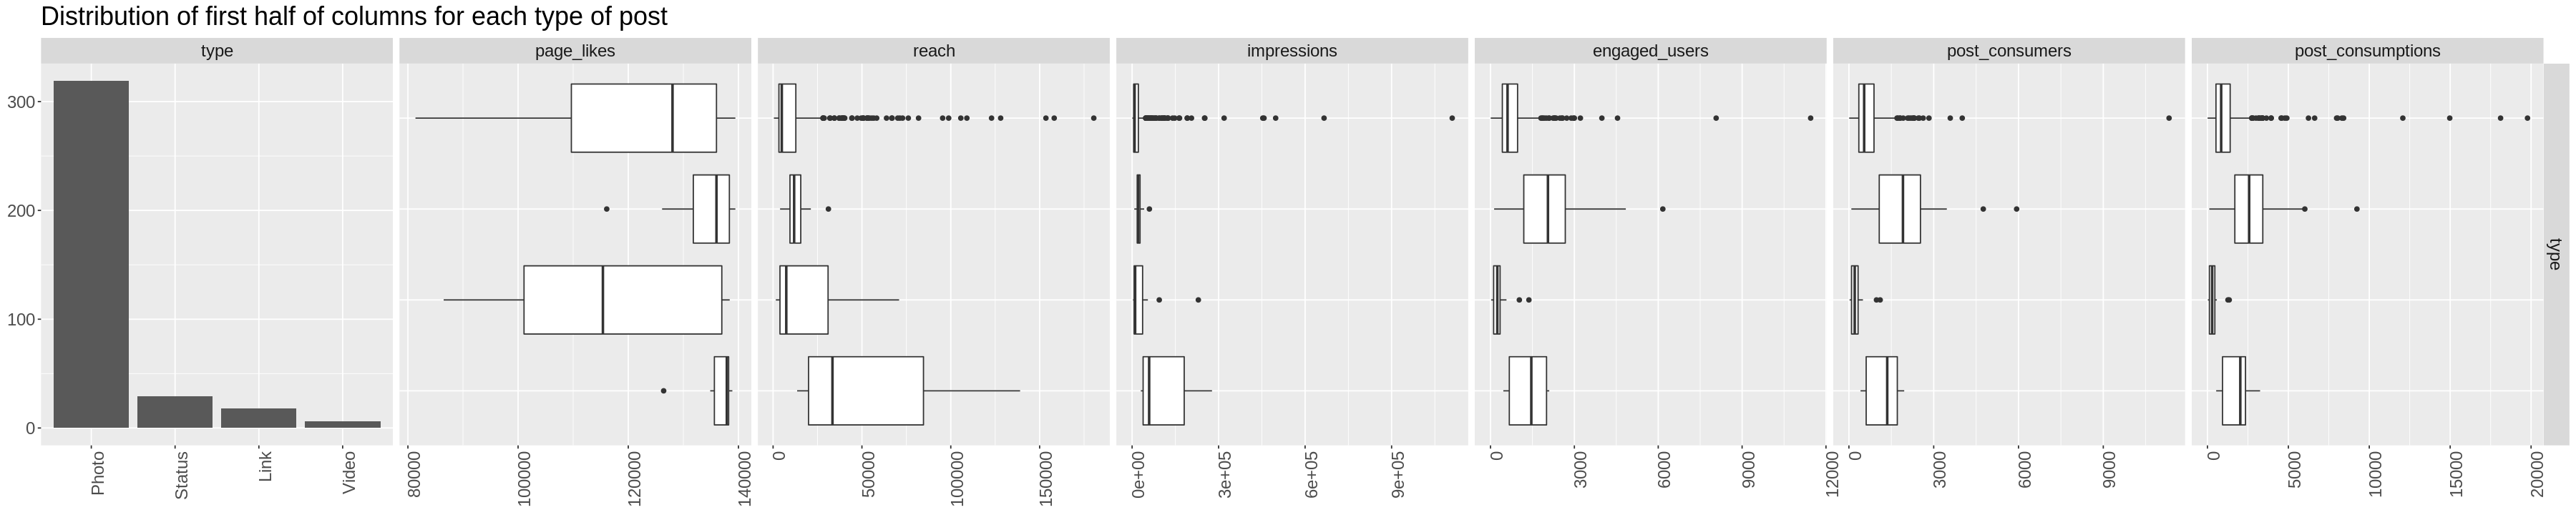

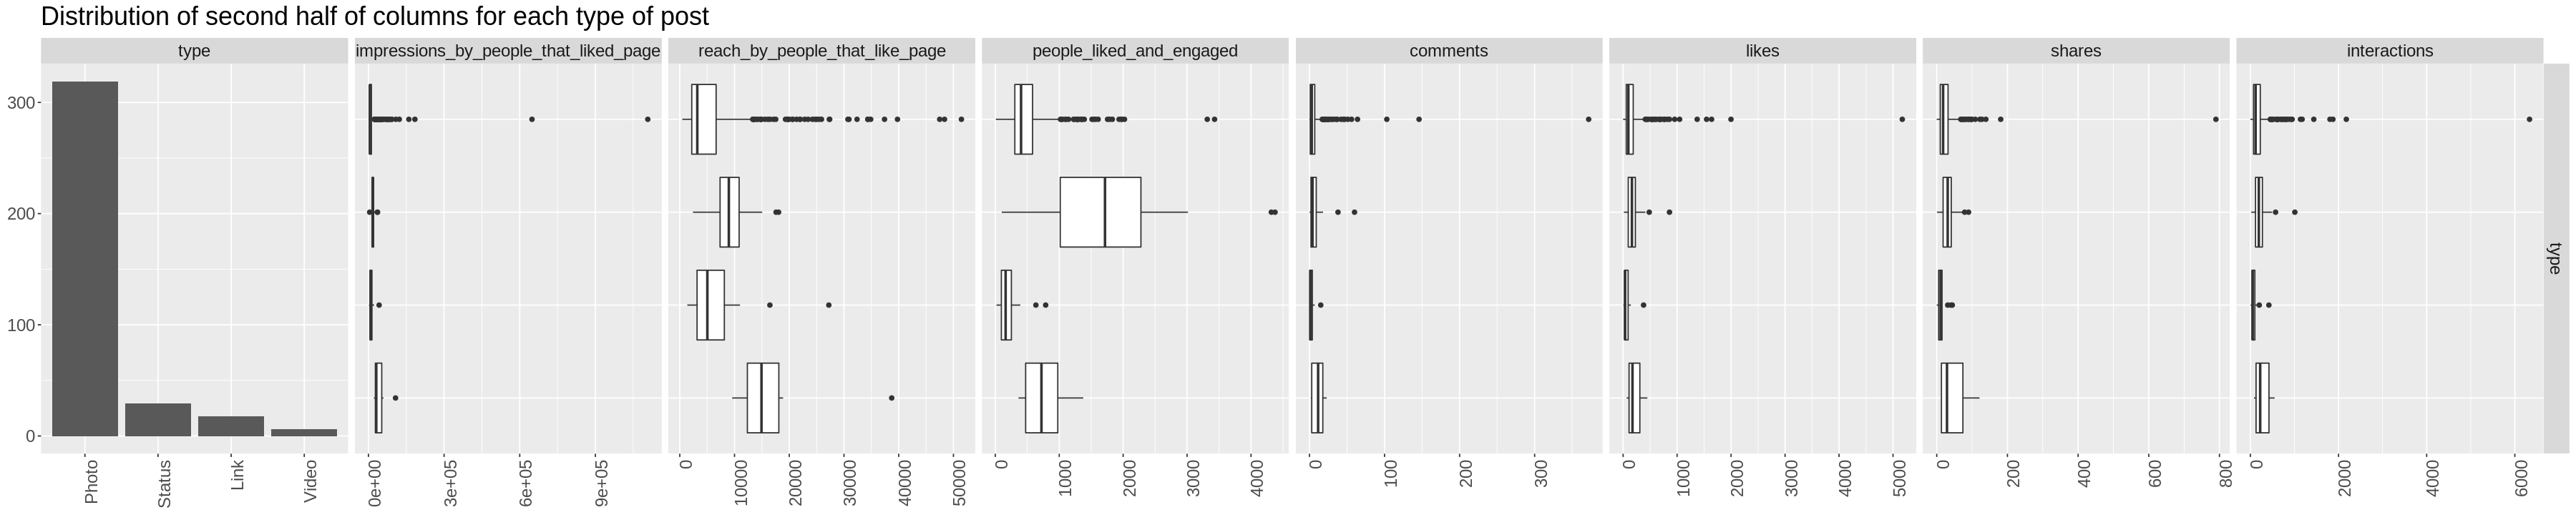

In [7]:
options(repr.plot.height = 6, repr.plot.width = 30)
fb_select_plot1_first <- fb_train_selected1 %>%
    select(type:post_consumptions) %>% 
    ggpairs() +
    ggtitle("Distribution of first half of columns for each type of post") +
    theme(text = element_text(size=18),
            axis.text.x = element_text(angle = 90, hjust = 1))

fb_select_plot1_second <- fb_train_selected1 %>%
    select(type, impressions_by_people_that_liked_page:interactions) %>% 
    ggpairs() +
    ggtitle("Distribution of second half of columns for each type of post") +
    theme(text = element_text(size=18),
            axis.text.x = element_text(angle = 90, hjust = 1))

# Select just the top row of each plot because it is the only thing that we are trying to compare
fb_select_plot1_first$nrow <- 1
fb_select_plot1_first$yAxisLabels <- fb_select_plot1_first$yAxisLabels[1]
fb_select_plot1_first

fb_select_plot1_second$nrow <- 1
fb_select_plot1_second$yAxisLabels <- fb_select_plot1_second$yAxisLabels[1]
fb_select_plot1_second

Looking at this plot, we can begin to analyze which predictors may or may not be good classifiers for our target variable. We want to avoid using predictors that have minimal variability within each type, and those which have a high level of overlap between all types.
- we eliminate `page_likes` because this column measures the total likes of the facebook page at the time a post was published, and is not necessarily related to any specific post.
- similarly, we eliminate `reach` as this column is simply the number of users for whom the post showed up on their facebook feed, and sheds no light on how the user may have interacted with the post. 
- we eliminate `impressions` because the difference of the boxes in the first three types look the same, meaning there is less variation in the data. While the boxplot for videos does look different from the rest, the many outliers of the boxplot of photos occupy similar space.
- we will keep only one of `engaged_users`, `post_consumers`, and `post_consumptions`. This is because they all effectively measure the same variable, in a slightly different way: `engaged_users` is the number of *unique* users that clicked in a post; `post_consumers` is the number of people that clicked in a post; `post_consumptions` is the number of clicks in a post. We will keep `post_consumptions` as a predictor and eliminate the other two, as this variable is more indicative of post type; from the boxplot, it appears that with photos in particular, users may return to the post and continue interacting after the initial view. We want to include this data in our classifier, as it should help with predictions.
- we eliminate `impressions_by_people_that_liked_page`, as each box plot is essentially a vertical line. 

The `comments`, `likes`, `shares`, and `interactions` boxplots appear to have similar low variability issues as `impressions`. We suspect that these columns should be useful as predictors, but the scale is such that it is hard to see any significant differences. Since the `interactions` column simply gives the total of all comments, likes, and shares on a post, we can convert each of these columns to a ratio of total interactions. This standardization of the data will allow a more meaningful comparison than their raw values, as the raw values are more a measure of popularity of the page, and are not themselves characteristic of the post type. This also allows us to eliminate the `interactions` column as a potential standalone predictor.

Similar to the above thinking, we will add a column which we call the `engagement ratio`. As stated above, we gain nothing from comparing the `reach` of a post, as the appearance of a post on a user's facebook page does not indicate their interaction with it. We instead will calculate another ratio of `interactions` over `reach`; this gives the percentage of total reached users who actually *interacted* with a post [3].

In the following column, we remove the eliminated columns and perform the changes suggested above. We again use the `na.omit` function to remove any missing values which may have been introduced by the mutations.

In [8]:
fb_train_selected2 <- fb_train_selected1 %>% 
            mutate(comment_ratio = comments / interactions) %>% 
            mutate(like_ratio = likes / interactions) %>% 
            mutate(share_ratio = shares / interactions) %>% 
            mutate(engagement_ratio = interactions / reach) %>%
            select(-page_likes, -reach, -impressions, -engaged_users, -post_consumers, -impressions_by_people_that_liked_page) %>% 
            select(-comments, -likes, -shares, -interactions) %>% # We don't need these anymore because they have been scaled
            na.omit()        

fb_test_selected2 <- fb_test_selected1 %>% 
            mutate(comment_ratio = comments / interactions) %>% 
            mutate(like_ratio = likes / interactions) %>% 
            mutate(share_ratio = shares / interactions) %>% 
            mutate(engagement_ratio = interactions / reach) %>%
            select(-page_likes, -reach, -impressions, -engaged_users, -post_consumers, -impressions_by_people_that_liked_page) %>% 
            select(-comments, -likes, -shares, -interactions) %>% 
            na.omit()

We again use the ggpairs function to observe boxplots of the remaining and new potential predictors:

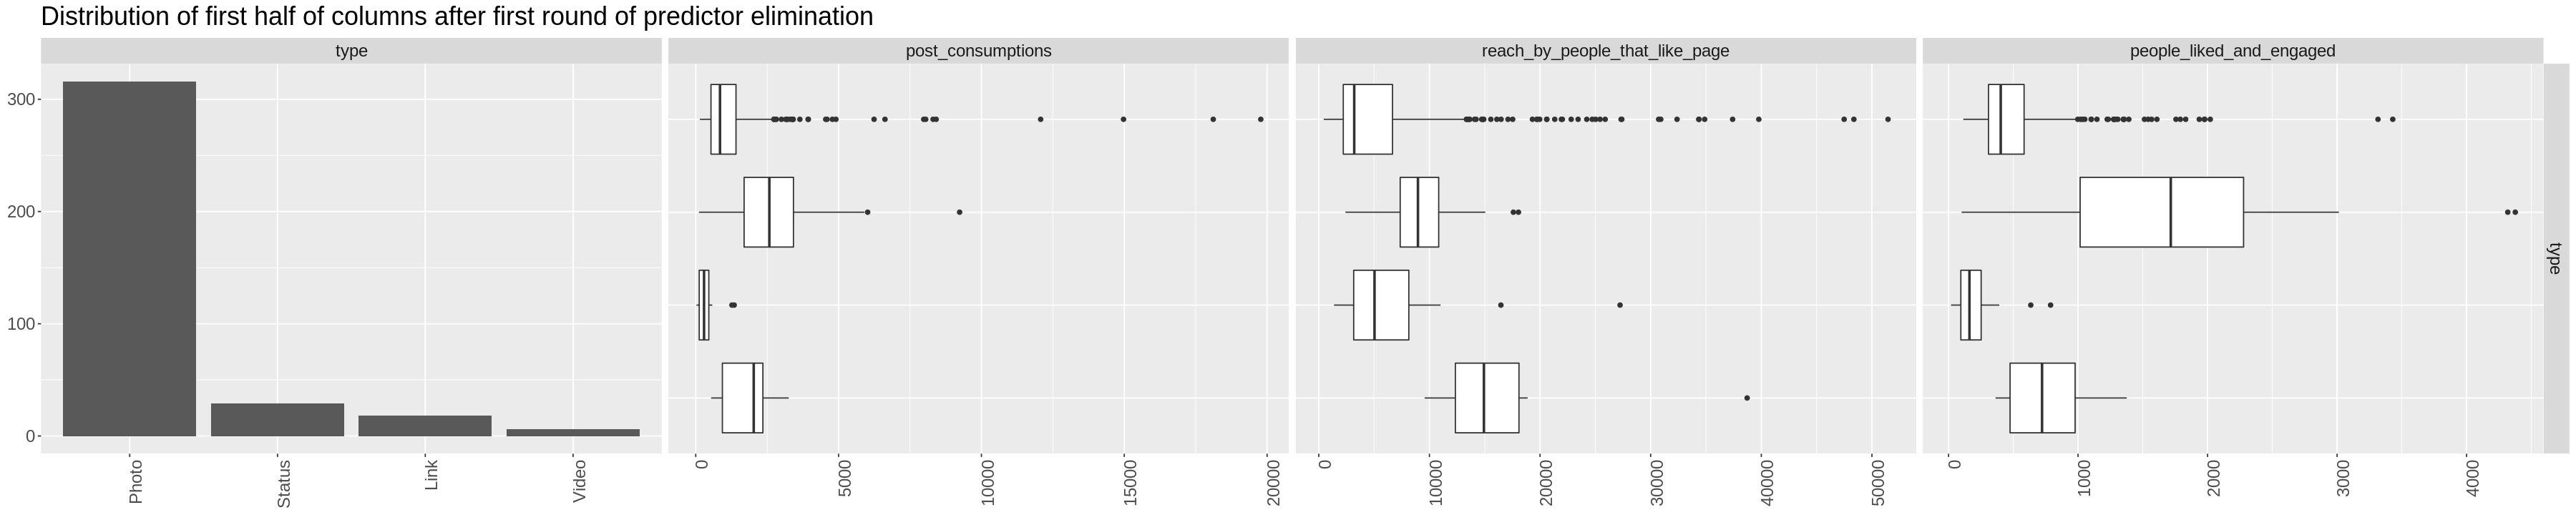

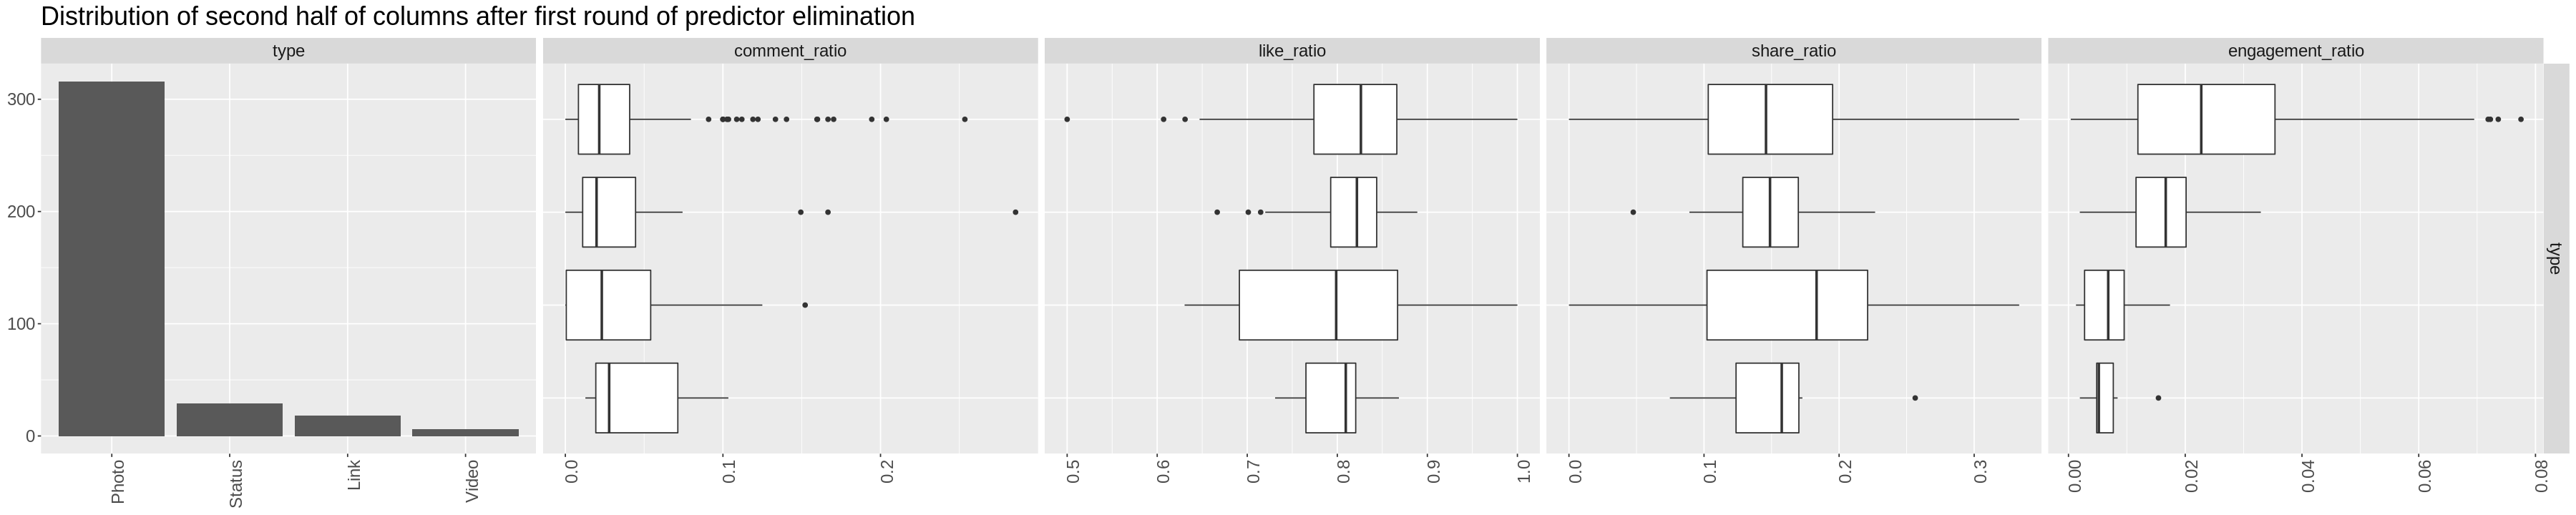

In [9]:
options(repr.plot.height = 6, repr.plot.width = 30)
fb_select_plot2_first <- fb_train_selected2 %>%
    select(type:people_liked_and_engaged) %>% 
    ggpairs() +
    ggtitle("Distribution of first half of columns after first round of predictor elimination") +
    theme(text = element_text(size=18),
        axis.text.x = element_text(angle = 90, hjust = 1))

fb_select_plot2_second <- fb_train_selected2 %>% 
    select(type, comment_ratio:engagement_ratio) %>% 
    ggpairs() +
    ggtitle("Distribution of second half of columns after first round of predictor elimination") +
    theme(text = element_text(size=18),
        axis.text.x = element_text(angle = 90, hjust = 1))

# Select just the top row of each plot, because it is the only thing that we are trying to compare
fb_select_plot2_first$nrow <- 1
fb_select_plot2_first$yAxisLabels <- fb_select_plot2_first$yAxisLabels[1]
fb_select_plot2_first

fb_select_plot2_second$nrow <- 1
fb_select_plot2_second$yAxisLabels <- fb_select_plot2_second$yAxisLabels[1]
fb_select_plot2_second

As seen in the plots above, `comment_ratio`, `like_ratio`, and `share_ratio` look very different now. `comment_ratio` still does not appear that it would be a great predictor, as there is a lot of overlap between post types and not a lot of variability within post types. But, `like_ratio`, and `share_ratio` appear to be useful as the variance in and between each plot is higher.

In [10]:
fb_train_selected_final <- fb_train_selected2 %>% 
            select(-comment_ratio)

fb_test_selected_final <- fb_test_selected2 %>% 
            select(-comment_ratio)

Now, our training and testing data set contain the following 7 columns:

In [11]:
colnames(fb_train_selected_final)
colnames(fb_test_selected_final)

[1] "type"                           "post_consumptions"             
[3] "reach_by_people_that_like_page" "people_liked_and_engaged"      
[5] "like_ratio"                     "share_ratio"                   
[7] "engagement_ratio"

[1] "type"                           "post_consumptions"             
[3] "reach_by_people_that_like_page" "people_liked_and_engaged"      
[5] "like_ratio"                     "share_ratio"                   
[7] "engagement_ratio"

#### Methods:

Our analysis will use the following input columns of the original dataset: type `page_likes`, `paid`, `reach`, `engaged_users`, `post_consumers`, `post_consumptions`, `reach_by_people_that_like_page`, and `people_liked_and_engaged`. We will also be using the generated columns `comment_percent`, `like_percent`, `share_percent`, and `engagement_ratio`.


Our aim is to use the K-nearest neighbours algorithm to generate a classification model which will classify a post by type (photo, status, link, or video).

To visualize our results, we plan to use a confusion matrix. This will display how often our classification model labels a post correctly, and how often each label gets confused with another. As part of the tuning step of creating the model, we can create a line chart to show us the optimal K value. 

#### Creating the model:

First, a table was constructed to gain a necessary summary of the training data. Table `summary_table1` groups posts by type and computes the total of each.

In [12]:
summary_table1 = fb_train_selected_final %>% 
    group_by(type) %>%
    summarize(total_of_type = n())

summary_table1

`summarise()` ungrouping output (override with `.groups` argument)



type,total_of_type
<fct>,<int>
Photo,316
Status,29
Link,18
Video,6


Looking at the number of each type of post, it is clear that we have a *class imbalance* in our training data. This occurs when one categorical label is much more common than another or others. If we do not fix this imbalance, since there is a much higher number of photos in the data than any other post type, we are much more likely to choose neighbours that are photos when using the KNN classification algorithm. This does raise some concerns about how well our model will be able to predict type (namely, posts that are of type `video`, with few observations), but we will attempt to maximize the accuracy of our results. We use the method of *oversampling*, which replicates observations of the rarer classes multiple times, making the number of observations of each type equal. Oversampling can be implemented with the `step_upsample` function.

In [13]:
upsample_recipe <- recipe(type ~ ., data = fb_train_selected_final) %>% 
                    step_upsample(type, over_ratio = 1, skip = FALSE ) %>% 
                    prep()
upsample_recipe

fb_train_upsampled <- upsample_recipe %>% bake(fb_train_selected_final)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Training data contained 369 data points and no missing data.

Operations:

Up-sampling based on type [trained]

In [14]:
summary_table2 = fb_train_upsampled %>% 
    group_by(type) %>%
    summarize(total_of_type = n())

summary_table2

`summarise()` ungrouping output (override with `.groups` argument)



type,total_of_type
<fct>,<int>
Photo,316
Status,316
Link,316
Video,316


Now that the class imbalance has been fixed, we can proceed with creating our classification model. In the following cell, we create the model recipe. We will attempt to predict `type` from all columns we have left in our data frame as predictors. We include a `step_scale` and `step_center` to center and scale the data as good practice, to ensure that no variable which may be on a larger scale than another will dominate the predictions. The `prep` functions is used to compute anything necessary to run the recipe, e.g., the data's column means and standard deviations.

In [15]:
# Create the recipe
fb_recipe <- recipe(type ~  ., data = fb_train_upsampled) %>%
                step_scale(all_predictors()) %>% 
                step_center(all_predictors()) %>% 
                prep()
                
fb_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Training data contained 1264 data points and no missing data.

Operations:

Scaling for 6 items [trained]
Centering for 6 items [trained]

We use the `bake` function to apply the recipe, so we can ensure that our changes have been applied and we are using the desired columns:

In [16]:
baked_fb <- bake(fb_recipe, fb_train_upsampled)
baked_fb

post_consumptions,reach_by_people_that_like_page,people_liked_and_engaged,like_ratio,share_ratio,engagement_ratio,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.8264904,-0.99804010,-0.8315941,-0.1944982,0.2177042,1.7757635,Photo
-0.8293038,-1.01387911,-0.8166384,0.2715454,0.2902745,1.5212512,Photo
-0.7111437,-0.10920549,-0.5324801,1.1699856,-0.8450986,0.7784286,Photo
-0.7443411,0.09057419,-0.4830112,2.0518591,-1.6502836,0.8460637,Photo
-0.7752878,-0.91896064,-0.7395590,-0.1176057,0.4078178,1.2892119,Photo
-0.8343678,-0.93630263,-0.7786739,0.3406354,0.2149657,1.5938400,Photo
-0.8214264,-0.96601523,-0.7579660,1.2877305,-1.2948122,3.6380821,Photo
-0.6813224,1.04507713,-0.1815963,2.1127118,-1.7650745,0.9725360,Photo
⋮,⋮,⋮,⋮,⋮,⋮,⋮


We use the `knn_spec` function to create our *model specification*. We specify the `neighbours` parameter as `tune()`, a `tidymodels` function which will choose the value of K that gives the highest accuracy. The other parameters are typical of the KNN classification algorithm.  

In [17]:
# Create the tune spec
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
            set_engine("kknn") %>% 
            set_mode("classification")

Since we are attempting to tune our model for highest accuracy, we use *cross-validation*. This method comes from the idea that by further splitting our overall training data into a sub-training set and a "validation" set, we can train and evaluate a classifier on this training data, and choose the parameter that gives the best accuracy on our validation set. Building on this, we can use cross-validation to perform multiple different training/validation set splits. We do this using the `vfold_cv` function from `tidymodels`; this method splits our overall training data up in different ways, trains and evaluates a classifier for each split, and chooses the best value of K based on the all of the different results. This is useful because if we split the data only once, the choice of best parameter value will be influenced by whatever data is "lucky" enough to end up in the validation set. 

We pass in the `baked_fb` data set from above, and instruct the model to use 10 "folds". Generally, a higher number of folds will yield a more accurate parameter value, but the computation will take longer. We choose 10 as this is the upper bound on typical values for `v`.

In [18]:
# Create vfolds with v
fb_vfold <- vfold_cv(baked_fb, v = 10, strata = type)

We combine the recipe and model specification into a workflow using the following code. The `tune_grid` function is used to fit the model for each value in a range; we have given it a sequence of possible parameter values from 1 to 10. We use the `collect_metrics` function to aggregate the mean and standard error across the folds. 

In [19]:
gridvals = tibble(neighbors = 1:10)

fb_fit <- workflow() %>% 
        add_recipe(fb_recipe) %>% 
        add_model(knn_spec_tune) %>% 
        tune_grid(resamples = fb_vfold, grid = gridvals) %>% 
        collect_metrics()

fb_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9905242,10,0.001962996,Model01
1,roc_auc,hand_till,0.9936828,10,0.001308664,Model01
2,accuracy,multiclass,0.9905242,10,0.001962996,Model02
2,roc_auc,hand_till,0.9936828,10,0.001308664,Model02
3,accuracy,multiclass,0.9747228,10,0.004347723,Model03
3,roc_auc,hand_till,0.9936828,10,0.001308664,Model03
4,accuracy,multiclass,0.9747228,10,0.004347723,Model04
4,roc_auc,hand_till,0.9936741,10,0.001308000,Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮


By filtering for accuracy and taking the mean from each parameter value, we create a plot of accuracy vs. value of K:

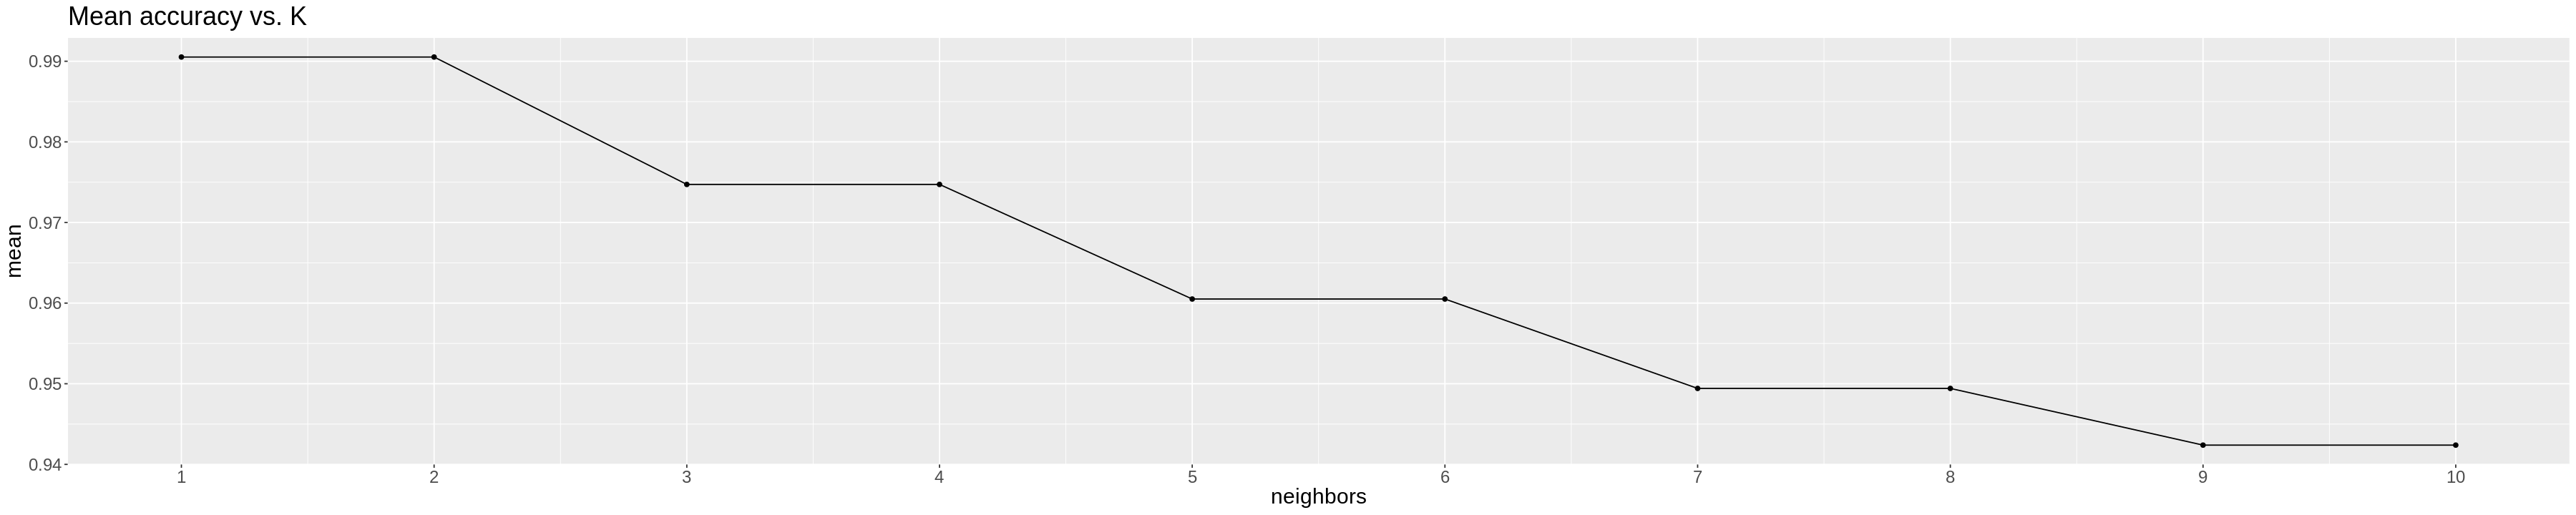

In [20]:
fb_filtered <- fb_fit %>% filter(.metric == "accuracy")

fb_filtered %>% ggplot(aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            ggtitle("Mean accuracy vs. K") +
            theme(text = element_text(size=18)) +
            scale_x_continuous(breaks = 1:10)

From this plot, we see that $K = 2$ is the value of K which yields the highest accuracy. We create a new model specification, this time using the chosen parameter value as the `neighbours` argument. We again combine the previous steps into a workflow, but this time we use the `fit` function instead of `tune_grid` to fit the model to our training data.

In [21]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(fb_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = baked_fb)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.009493671
Best kernel: rectangular
Best k: 2

Finally, we use the `predict` function to apply our classification model to our testing set! We use `bind_cols` to append the predicted columns to our testing data set, and in the following cell, we obtain the metrics of our predictions compared to our actual posts' types. 

In [22]:
fb_predictions <- predict(knn_fit, fb_test_selected_final) %>%
  bind_cols(fb_test_selected_final)
fb_predictions

.pred_class,type,post_consumptions,reach_by_people_that_like_page,people_liked_and_engaged,like_ratio,share_ratio,engagement_ratio
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Photo,Photo,1119,32048,1386,0.8846370,0.08272369,0.03544925
Photo,Photo,580,3200,396,0.8269720,0.12468193,0.05425179
Photo,Status,4540,18952,3798,0.9246032,0.07539683,0.01158940
Photo,Photo,133,2072,152,0.8653846,0.13461538,0.03652968
Photo,Status,1425,8548,1162,0.7962963,0.16666667,0.01073559
Photo,Photo,111,1161,100,0.8095238,0.19047619,0.02639849
Photo,Status,1489,5244,995,0.8181818,0.15702479,0.01425542
Photo,Photo,247,1676,194,0.7840000,0.18400000,0.04163891
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [27]:
fb_prediction_accuracy <- fb_predictions %>%
  metrics(truth = type, estimate = .pred_class)

print("Metrics for Tested Model")
fb_prediction_accuracy

[1] "Metrics for Tested Model"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8264463
kap,multiclass,0.0000000


The accuracy of the model when predicting on the test set is around 80%. We can further examine our results by creating a *confusion matrix* for the classifier; the columns represent the actual type of a post, while the rows represent the predicted type. We use the `conf_mat` function to create this matrix:

In [34]:
fb_type_mat <- fb_predictions %>% 
    conf_mat(truth = type, estimate = .pred_class)

print("Confusion Matrix for Results")
fb_type_mat

# percentage of posts in fb_test_selected_final that are photos
photos_percentage <- nrow(fb_test_selected_final %>% filter(type == "Photo")) / nrow(fb_test_selected_final) * 100

print("Percentage of Test Data that is photos:")
photos_percentage

[1] "Confusion Matrix for Results"


          Truth
Prediction Photo Status Link Video
    Photo    100     16    4     1
    Status     0      0    0     0
    Link       0      0    0     0
    Video      0      0    0     0

[1] "Percentage of Test Data that is photos:"


[1] 82.64463

With this visualization, it becomes apparent that our classifier predicted every post to be a photo. This is not an ideal outcome, but explains why we achieved a prediction accuracy of around 80%. The vast majority of posts in the data set, and thus in both the training and the testing set, were actually photos. Because of this, despite the oversampling performed, photo was predicted as the type 100% of the time, yielding the correct result *approximately* 80% of the time.

### Discussion:

In our analysis, we hoped to define a relationship between the predictors that that we selected, and the type of the post. Though Looking at the results, we were unsuccessful in this.

Dispite us having an 80% accuracy on the testing set, this is a result of the set having 80% photos. This is because the model we created is extremely overfitted and produces "Photo" as every result. We knew that this would be a problem from the inital exploration of the data, but we were hoping that this could be fixed by upsampling the data. This didn't work so for us to fix the problem with the model, we would have to use a different method of reducing the overfitting of the model.

We were hoping that this model would be able to show some relationships between the metrics a post would get, and the type of the post. We hoped that with an accurate model, companies would be able to create taylored posts that reach specific engagement that they wanted. If we found that high likes and general engagement were a characteristics of videos, companies would know that they should focus on posts of videos.

Future questions following from this analysis may include:
- Do paid posts generate more traffic than unpaid posts?
- Does the category of a post (i.e., “action”, “product”, or “inspiration” classification) affect the overall and/or ratio of interactions on a post?
- Do posts with more interactions overall correlate with increases in users liking a company’s Facebook page? 

### References: 
[1] Statista, "Global social networks ranked by number of users 2021", 2021 [Online]. Available: https://www-statista-com.ezproxy.library.ubc.ca/statistics/272014/global-social-networks-ranked-by-number-of-users/. [Accessed: 28- Feb- 2021]

[2] S. Moro, P. Rita and B. Vala, "Predicting social media performance metrics and evluation of the impact on brand building: A data mining approach", *Journal of Business Research*, vol. 69, no. 9, 2021.

[3] E. Ernoult, “6 Facebook Metrics Marketers Should Be Measuring : Social Media Examiner,” Social Media Examiner | Social Media Marketing. [Online]. Available: https://www.socialmediaexaminer.com/facebook-page-metrics/. [Accessed: 12-Apr-2021]. 
